# Draw

In [1]:
import numpy  as np
from random import uniform
from copy import copy
import math
from io import BytesIO
import cairo
import IPython.display

In [2]:
XMAX = 100
XMIN = -95

YMAX = 185
YMIN = -90

XMID = (XMAX + XMIN) / 2.0
YMID = (YMAX + YMIN) / 2.0

PEN_DELAY = 125

START_X = 0
START_Y = -200

In [3]:
def clamp(value, min_value, max_value):
    return min(max(value, min_value), max_value)

In [4]:
class GCODE:
    def __init__(self, name="foobar", feedrate=1000):
        self.start_pos = np.array([START_X, START_Y])
        self.pos = copy(self.start_pos)
        self.f = open(f"{name}.gcode", "wt")
        self.feedrate = feedrate
        
        self.servo = "P0"
        self.pen_up_pos = "S0"
        self.pen_down_pos = "S90"
         
        self.f.write("M17\n")  # Ensure steppers are enabled
        self.f.write("M121\n")  # Disable endstops, just in case
        self.f.write("G90\n")  # Set absolute positioning
        self.f.write("; potatolangelo\n")
        self.pen_up()
        self.move_to_starting_position()
        
    def pen_up(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_up_pos} T{PEN_DELAY}\n")
    
    def pen_down(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_down_pos} T{PEN_DELAY}\n")
        
    def finish_moves(self):
        self.f.write("M400\n")
        
    def move_to(self, x, y, feedrate=None):
        feedrate = feedrate or self.feedrate
        
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def move_to_mid_point(self, feedrate=None):
        self.move_to(XMID, YMID, feedrate=feedrate)
        
    def move_to_starting_position(self, feedrate=None):
        self.move_to(START_X, START_Y, feedrate=feedrate)
        
    def step(self, dx, dy, feedrate=None):
        feedrate = feedrate or self.feedrate
        self.pos[0] += dx
        self.pos[1] += dy
        
        x = self.pos[0]
        y = self.pos[1]
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def square_filled(self, xmin, ymin, xmax, ymax, dy=1, zigzag=True):
        print(f"square filled centered on {(xmin + xmax) / 2.0:.2f} {(ymin + ymax) / 2.0:.2f}")
        
        self.pen_up()    
        self.move_to((xmin + xmax) / 2.0, (ymin + ymax) / 2.0)
        
        self.square(xmin, ymin, xmax, ymax)
        
        self.pen_up()    
        self.move_to(xmin, ymin)
        self.pen_down()
        
        x = xmin
        y = ymin
        while y < ymax:
            y += dy
            
            # When zigzag is true the pen moves in a saw tooth pattern,
            # otherwise it goes in a square wave form.
            # Zigzag looks good with ballpoint pens, while the square pattern
            # works best on thicker points.
            if not zigzag:
                self.move_to(x, y)
            
            if x == xmin:
                x = xmax
            else:
                x = xmin
                
            self.move_to(x, y)
            
        self.pen_up()
                
    def square(self, xmin, ymin, xmax, ymax):
        self.move_to(xmin, ymin)
        self.pen_down()
        self.move_to(xmax, ymin)
        self.move_to(xmax, ymax)
        self.move_to(xmin, ymax)
        self.move_to(xmin, ymin)
        self.pen_up()
            
    def flush(self):
        self.f.flush()

In [5]:
gcode = GCODE("squares", feedrate=1000)
gcode.move_to_mid_point()

square_size = 10

x = XMID
y = YMID

gcode.pen_up()
gcode.square_filled(x - square_size, y - square_size, x + square_size, y + square_size)
for _ in range(10):
    square_size = uniform(5, 15)
    
    x = uniform(XMIN + square_size, XMAX - square_size)
    y = uniform(YMIN - square_size, YMAX + square_size)
    
    gcode.square_filled(x - square_size, y - square_size, x + square_size, y + square_size)

gcode.move_to_mid_point()
gcode.move_to_starting_position()
gcode.flush()

square filled centered on 2.50 47.50
square filled centered on 52.50 31.79
square filled centered on -30.04 174.25
square filled centered on -72.89 90.29
square filled centered on -33.79 110.03
square filled centered on 37.75 -49.08
square filled centered on 66.81 17.68
square filled centered on -28.81 -15.91
square filled centered on 57.47 67.62
square filled centered on -37.68 153.22
square filled centered on -26.87 -60.84


In [6]:
gcode = GCODE("foobar", feedrate=5000)

gcode.move_to(0, 50)
gcode.move_to(-50, 50)
gcode.move_to(-50, 0)
gcode.move_to(-50, -50)
gcode.move_to(0, -50)
gcode.move_to(50, -50)
gcode.move_to(50, 0)
gcode.move_to(50, 50)
gcode.move_to(0, 50)

gcode.move_to_starting_position()

gcode.flush()

In [7]:
gcode = GCODE("random", feedrate=1000)

size = 5

gcode.move_to(XMID, YMID, feedrate=5000)

for _ in range(100):
    gcode.step(
        uniform(-size, size),
        uniform(-size, size)
    )

gcode.move_to_starting_position()

gcode.flush()

In [8]:
size = 5
radius = 0
n_steps = 360 * 2
angle = 0

noise = 2

gcode = GCODE("spiral2", feedrate=1500)
gcode.move_to(XMID, YMID, feedrate=5000)


for _ in range(n_steps):
    radius += XMAX / float(n_steps)
    
    gcode.move_to(
        radius * math.sin(angle) + XMID + uniform(-noise, noise),
        radius * math.cos(angle) + YMID + uniform(-noise, noise),
    )
    
    angle += math.radians(1)

gcode.move_to_starting_position()

gcode.flush()

In [9]:
gcode = GCODE("bounding", feedrate=2000)

gcode.pen_up()
gcode.move_to(XMIN, YMIN)

# Square
gcode.pen_down()
gcode.move_to(XMIN, YMAX)
gcode.move_to(XMAX, YMAX)
gcode.move_to(XMAX, YMIN)
gcode.move_to(XMIN, YMIN)

# Cross
gcode.pen_down()
gcode.move_to(XMAX, YMAX)
gcode.pen_up()
gcode.move_to(XMAX, YMIN)
gcode.pen_down()
gcode.move_to(XMIN, YMAX)
gcode.pen_up()

gcode.move_to_starting_position()

gcode.flush()

# Preview

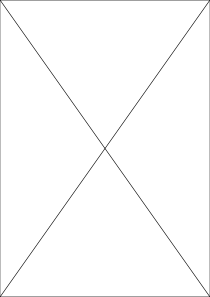

In [10]:
svgio = BytesIO()
filename = "bounding.gcode"

last_x = (START_X - XMIN) / (XMAX - XMIN)
last_y = (START_Y - YMIN) / (YMAX - YMIN)

width = 210
height = 297

drawing = False

with cairo.SVGSurface(svgio, width, height) as surface, open(filename) as f:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.0025)
    context.set_source_rgba(0, 0, 0, 1)
    
    for line in f.readlines():
        if "G0" in line:
                
            tokens = line.strip().split(" ")[1:]
            x = (float(tokens[0][1:]) - XMIN) / (XMAX - XMIN)
            y = (float(tokens[1][1:]) - YMIN) / (YMAX - YMIN)

            if writing:  
                context.move_to(last_x, last_y)
                context.line_to(x, y)
                context.stroke()

            last_x = x
            last_y = y
            
        if "M280 P0" in line:
            tokens = line.strip().split(" ")[1:]
            if tokens[1] == "S0":
                writing = False
            elif tokens[1] == "S90":
                writing = True

IPython.display.SVG(data=svgio.getvalue())